S## Imports

In [1]:
import json
import hashlib
from pathlib import Path
from typing import List, Dict, Any, Optional

import pandas as pd
import matplotlib.pyplot as plt

## Setup

In [2]:
ROCLICO_ROOT = Path("")

TRAIN_DIR = ROCLICO_ROOT / "Train"
TEST_DIR  = ROCLICO_ROOT / "Test"

print("ROCLICO_ROOT:", ROCLICO_ROOT.resolve())
print("Train exists:", TRAIN_DIR.exists(), "->", TRAIN_DIR)
print("Test  exists:", TEST_DIR.exists(),  "->", TEST_DIR)

ROCLICO_ROOT: D:\Programming\AI\AI-Self\NLP-FakeNews-Detection-Classifier\dataset-creation\RoCliCo
Train exists: True -> Train
Test  exists: True -> Test


## Load JSON files

In [3]:
def read_json_list(path: Path) -> List[Dict[str, Any]]:
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"{path} is not a JSON list. Found type={type(data)}")
    return data

def normalize_ws(s: Optional[str]) -> str:
    s = s or ""
    return " ".join(str(s).split())

def md5_text(s: str) -> str:
    return hashlib.md5(s.encode("utf-8")).hexdigest()

def load_split(split_name: str, split_dir: Path) -> pd.DataFrame:
    rows = []
    for fp in sorted(split_dir.glob("*.json")):
        src = fp.stem
        items = read_json_list(fp)
        for i, obj in enumerate(items):
            title = normalize_ws(obj.get("title"))
            content = normalize_ws(obj.get("content"))
            category = normalize_ws(obj.get("category")).lower()
            rows.append({
                "split": split_name,
                "source_file": src,
                "idx_in_file": i,
                "title": title,
                "content": content,
                "category": category,
            })
    df = pd.DataFrame(rows)
    if len(df) == 0:
        return df

    df["title_len"] = df["title"].fillna("").apply(len)
    df["content_len"] = df["content"].fillna("").apply(len)
    df["text_len"] = df["title_len"] + df["content_len"]

    df["title_md5"] = df["title"].fillna("").apply(md5_text)
    df["content_md5"] = df["content"].fillna("").apply(md5_text)
    df["pair_md5"] = (df["title"].fillna("") + "\n" + df["content"].fillna("")).apply(md5_text)

    return df

train_df = load_split("train", TRAIN_DIR)
test_df  = load_split("test", TEST_DIR)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))
train_df.head(3)


Train rows: 6806
Test rows : 1507


,split,source_file,idx_in_file,title,content,category,title_len,content_len,text_len,title_md5,content_md5,pair_md5
0,train,cancan,0,Cât a ajuns să coste un kilogram de cozonac în...,Cozonacul este alimentul „vedetă” care nu lips...,clickbait,131,1775,1906,03f12eb1c86c4d523510dfc1684cb861,d902eefe645f5553f681c9f288c6e88c,39337df7970f1ca7f81bba252add9a9d
1,train,cancan,1,Doliu în lumea artistică. Compozitorul Angelo ...,Este doliu în lumea artistică. Compozitorul An...,nonclickbait,78,1969,2047,23cfe780420c123debc4fe8d28f65a47,87138639b9298cb9942f7b9157ff3892,c1fa935517912cd72ca7221442e75226
2,train,cancan,2,Imagini rare cu Nicolae Ceaușescu! Cum control...,Nicolae Ceaușescu nu a fost doar președintele ...,clickbait,131,1855,1986,7dfc7e56a757d4821941fab9eecfc695,258f43d9f15d01c91893f44a03bf29c8,6508d2536444c80662350a43b4d96219


## Labels check

In [4]:
def show_value_counts(df: pd.DataFrame, col: str, by: Optional[str] = None, topn: int = 20):
    if df.empty:
        print("Empty dataframe.")
        return
    if by is None:
        display(df[col].value_counts(dropna=False).head(topn))
    else:
        display(
            df.groupby(by)[col]
            .value_counts(dropna=False)
            .rename("count")
            .reset_index()
            .sort_values(["count"], ascending=False)
            .head(200)
        )

print("Train category distribution:")
show_value_counts(train_df, "category")

print("\nTest category distribution:")
show_value_counts(test_df, "category")

print("\nTrain category by source_file:")
show_value_counts(train_df, "category", by="source_file")

print("\nTest category by source_file:")
show_value_counts(test_df, "category", by="source_file")

Train category distribution:


category
nonclickbait    3527
clickbait       3279
Name: count, dtype: int64


Test category distribution:


category
nonclickbait    1066
clickbait        441
Name: count, dtype: int64


Train category by source_file:


,source_file,category,count
0,cancan,clickbait,2407
1,cancan,nonclickbait,2265
2,protv,nonclickbait,849
3,protv,clickbait,578
4,wowbiz,nonclickbait,413
5,wowbiz,clickbait,294



Test category by source_file:


,source_file,category,count
2,libertatea,nonclickbait,513
0,digi,nonclickbait,420
4,viva,clickbait,267
5,viva,nonclickbait,133
3,libertatea,clickbait,92
1,digi,clickbait,82


## Length

In [5]:
def describe_lengths(df: pd.DataFrame, name: str):
    if df.empty:
        print(f"{name}: empty")
        return
    print(f"\n{name} length stats")
    display(df[["title_len","content_len","text_len"]].describe(percentiles=[0.5,0.75,0.9,0.95,0.99]))

describe_lengths(train_df, "TRAIN")
describe_lengths(test_df, "TEST")



TRAIN length stats


,title_len,content_len,text_len
count,6806.000000,6806.000000,6806.000000
mean,102.387599,2136.692183,2239.079783
std,26.309628,1010.931507,1012.612101
min,28.000000,0.000000,120.000000
50%,101.000000,2006.000000,2113.000000
75%,117.000000,2415.000000,2521.750000
90%,135.000000,3028.500000,3138.000000
95%,148.000000,3693.750000,3815.750000
99%,175.950000,5713.600000,5800.800000
max,248.000000,24338.000000,24438.000000



TEST length stats


,title_len,content_len,text_len
count,1507.000000,1507.000000,1507.000000
mean,119.531520,3571.193762,3690.725282
std,30.380164,3703.972358,3709.992512
min,23.000000,412.000000,469.000000
50%,118.000000,2916.000000,3029.000000
75%,136.000000,4137.000000,4270.000000
90%,160.000000,5590.200000,5790.000000
95%,175.000000,7651.000000,7796.900000
99%,197.940000,18703.880000,18812.220000
max,237.000000,62884.000000,62974.000000


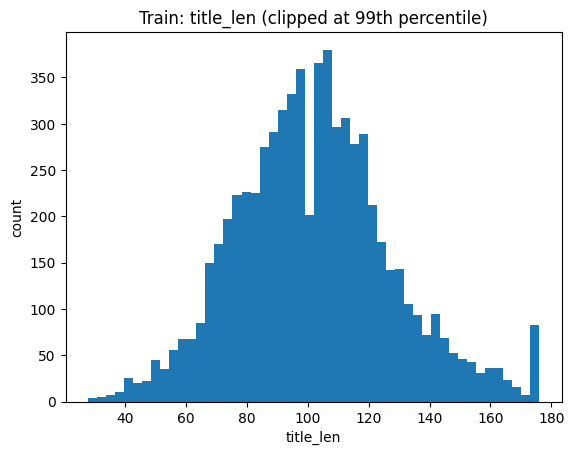

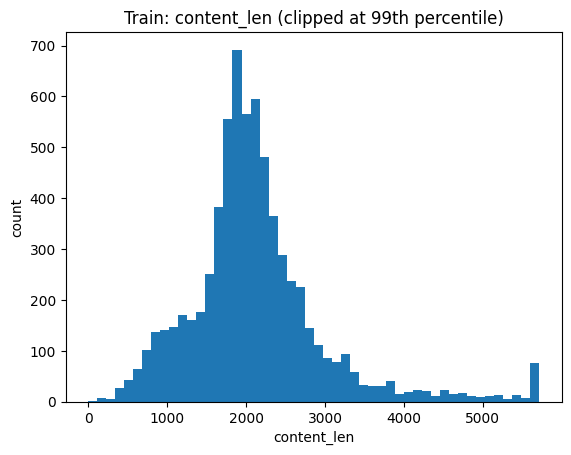

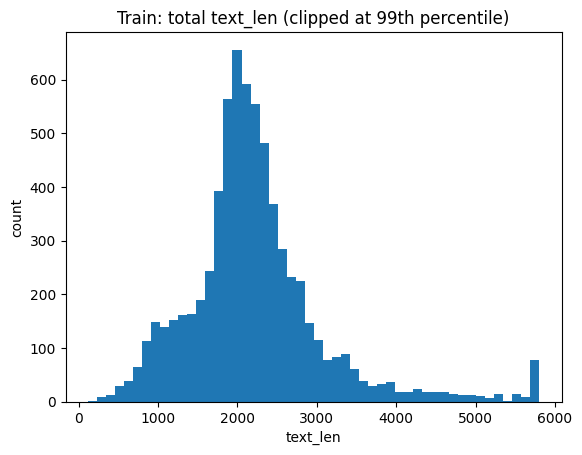

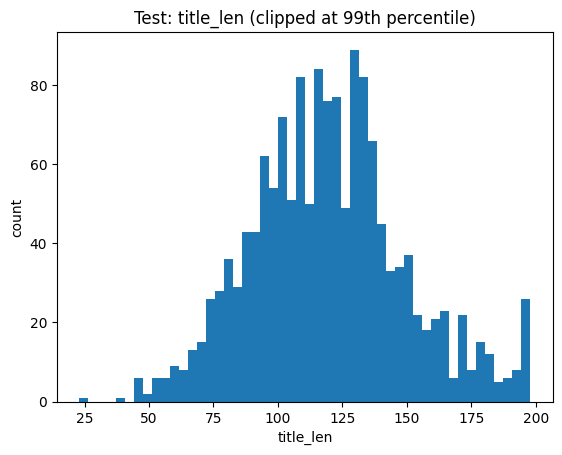

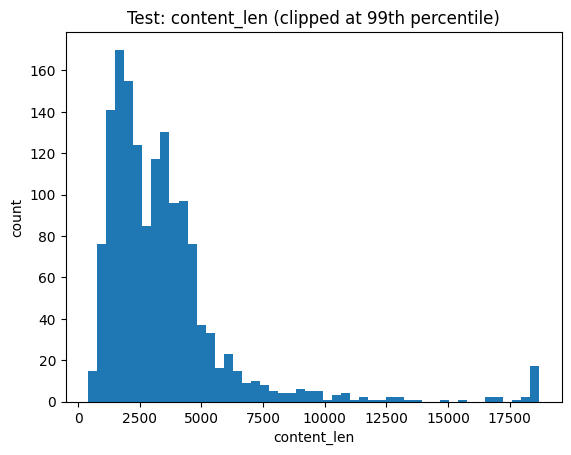

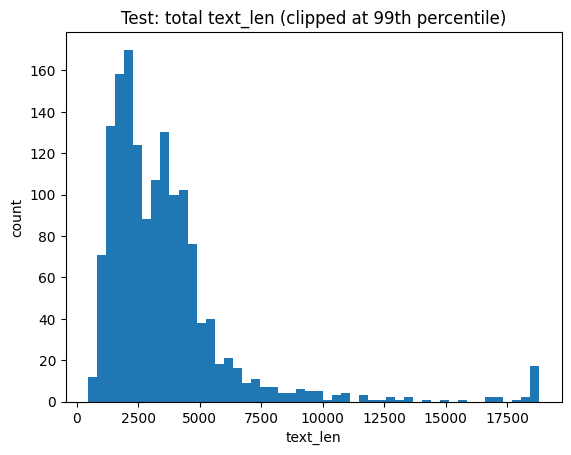

In [6]:
def plot_hist(df: pd.DataFrame, col: str, title: str, bins: int = 50):
    if df.empty:
        return
    clip_val = df[col].quantile(0.99)
    plt.figure()
    plt.hist(df[col].clip(upper=clip_val), bins=bins)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

plot_hist(train_df, "title_len", "Train: title_len (clipped at 99th percentile)")
plot_hist(train_df, "content_len", "Train: content_len (clipped at 99th percentile)")
plot_hist(train_df, "text_len", "Train: total text_len (clipped at 99th percentile)")

plot_hist(test_df, "title_len", "Test: title_len (clipped at 99th percentile)")
plot_hist(test_df, "content_len", "Test: content_len (clipped at 99th percentile)")
plot_hist(test_df, "text_len", "Test: total text_len (clipped at 99th percentile)")


## Duplicate check

In [7]:
def duplicate_report(df: pd.DataFrame, name: str):
    if df.empty:
        print(f"{name}: empty")
        return
    n = len(df)
    d_title = n - df["title_md5"].nunique()
    d_cont  = n - df["content_md5"].nunique()
    d_pair  = n - df["pair_md5"].nunique()
    print(f"{name}: rows={n} | dup_title={d_title} | dup_content={d_cont} | dup_pair={d_pair}")

duplicate_report(train_df, "TRAIN")
duplicate_report(test_df, "TEST")

if not train_df.empty:
    dup_titles = train_df.groupby("title_md5").size().sort_values(ascending=False)
    dup_titles = dup_titles[dup_titles > 1].head(20)
    if len(dup_titles) == 0:
        print("No duplicated titles (exact) in TRAIN.")
    else:
        md5s = dup_titles.index.tolist()
        display(train_df[train_df["title_md5"].isin(md5s)][["source_file","category","title"]].head(50))

TRAIN: rows=6806 | dup_title=1460 | dup_content=1451 | dup_pair=1449
TEST: rows=1507 | dup_title=8 | dup_content=8 | dup_pair=8


,source_file,category,title
533,cancan,clickbait,Aparatul din casă care consumă cât 300 de becu...
1100,cancan,nonclickbait,Experiența trăită de un grup de tineri din Buc...
1101,cancan,nonclickbait,Alertă ANM! Meteorologii au emis un cod portoc...
1102,cancan,clickbait,Veste bună! A fost efectuată prima tranșă de 2...
1103,cancan,clickbait,Ajutor de 2000 de lei din partea Guvernului! C...
1107,cancan,clickbait,Ai făcut asta vreodată? Ce se întâmplă dacă ru...
1136,cancan,nonclickbait,Ion Iliescu se confruntă cu grave probleme de ...
1176,cancan,nonclickbait,Planta cu mult iod cu multiple beneficii! Cură...
1206,cancan,clickbait,Amendă pentru OMV. Cât are de plătit compania ...
1209,cancan,nonclickbait,Experiența trăită de un grup de tineri din Buc...


In [8]:
def leakage_report(train_df: pd.DataFrame, test_df: pd.DataFrame):
    if train_df.empty or test_df.empty:
        print("One split is empty; cannot compute leakage.")
        return

    title_overlap = len(set(train_df["title_md5"]) & set(test_df["title_md5"]))
    cont_overlap  = len(set(train_df["content_md5"]) & set(test_df["content_md5"]))
    pair_overlap  = len(set(train_df["pair_md5"]) & set(test_df["pair_md5"]))

    print("Exact-hash overlaps:")
    print(" - title overlap  :", title_overlap)
    print(" - content overlap:", cont_overlap)
    print(" - pair overlap   :", pair_overlap)

    if pair_overlap > 0:
        overlap_md5 = list(set(train_df["pair_md5"]) & set(test_df["pair_md5"]))[:20]
        print("\nExamples of exact (title+content) overlaps:")
        display(pd.concat([
            train_df[train_df["pair_md5"].isin(overlap_md5)].assign(where="train"),
            test_df[test_df["pair_md5"].isin(overlap_md5)].assign(where="test")
        ])[ ["where","source_file","category","title"] ].head(50))

leakage_report(train_df, test_df)

Exact-hash overlaps:
 - title overlap  : 0
 - content overlap: 0
 - pair overlap   : 0


## Save combined csv

In [9]:
combined = pd.concat([train_df, test_df], ignore_index=True) if (not train_df.empty and not test_df.empty) else (train_df if not train_df.empty else test_df)
out_path = ROCLICO_ROOT / "rocloco_combined.csv"
if len(combined) > 0:
    combined.to_csv(out_path, index=False, encoding="utf-8")
    print("Wrote:", out_path)
else:
    print("No data loaded; nothing written.")
out_path

Wrote: rocloco_combined.csv


WindowsPath('rocloco_combined.csv')